## Introdução

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado offline**.


## Sobre os dados


Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). Todos os dados são de pacientes mulheres de pelo menos 21 anos de idade. As *features* são:

* **Pregnancies**: Número de eventos de gravidez; 
* **Glucose**: Concentração de glicose plasmática;
* **BloodPressure**: Pressão sanguínea diastólica ($mmHg$);
* **SkinThickness**: Grossura da dobra da pele do tríceps ($mm$);
* **Insulin**: Insulina sérica ($\mu U/mL$);
* **BMI**: *Body mass index*, Peso em $kg$ / (altura em $m$)$^2$;
* **DiabetesPedigreeFunction**: mede a possibilidade de diabetes dado o histórico familiar;
* **Age**: Idade (anos);
* **Outcome**: Target, 0 para não-diabético, 1 para diabético.



## Problema de negócio e avaliação do modelo

O custo de exame e de prevenção são significativamente menores que os custos de tratamento da diabetes. Além disso, a detecção precoce facilita o tratamento (https://www.previva.com.br/reduzir-custo-do-diabetes/).

A principal métrica que utilizaremos para avaliar o modelo será o **recall**, mas também analisaremos a acurácia, precisão e F1 dos modelos. Compararemos nossos resultados com um modelo heurístico baseado na concentração de glicose.

## Importando e explorando os dados

In [1]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)

from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv("data/diabetes.csv")

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Checando linhas duplicadas

data.duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Não que seja necessário nesse caso, mas podemos reduzir o uso de memória alterando os dtypes.

In [8]:
# Reduzindo o uso de memória

int_cols = list(data.select_dtypes('int64').columns) 
float_cols = list(data.select_dtypes('float64').columns)

for col in int_cols:
    data[col] = data[col].astype('int32')
    
for col in float_cols:
    data[col] = data[col].astype('float32')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int32  
 1   Glucose                   768 non-null    int32  
 2   BloodPressure             768 non-null    int32  
 3   SkinThickness             768 non-null    int32  
 4   Insulin                   768 non-null    int32  
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int32  
 8   Outcome                   768 non-null    int32  
dtypes: float32(2), int32(7)
memory usage: 27.1 KB


Tivemos uma redução significativa de uso de memória.

In [10]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos ({100*data[col].eq(0).sum()/data.shape[0]:.1f} %) em {col}.")

111 valores nulos (14.5 %) em Pregnancies.
5 valores nulos (0.7 %) em Glucose.
35 valores nulos (4.6 %) em BloodPressure.
227 valores nulos (29.6 %) em SkinThickness.
374 valores nulos (48.7 %) em Insulin.
11 valores nulos (1.4 %) em BMI.
0 valores nulos (0.0 %) em DiabetesPedigreeFunction.
0 valores nulos (0.0 %) em Age.
500 valores nulos (65.1 %) em Outcome.


Valores nulos de `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` e `BMI` são na verdade dados faltantes (NaN). A coluna `Insulin` possui uma quantidade significativa de NaN.

Vamos inspecionar um pouco mais as colunas de `Glucose` e `BMI`:

In [11]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.700001,0.140,22,0
182,1,0,74,20,23,27.700001,0.299,21,0
342,1,0,68,35,0,32.000000,0.389,22,0
349,5,0,80,32,0,41.000000,0.346,37,1
502,6,0,68,41,0,39.000000,0.727,41,1


In [13]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias nulas em `Glucose` e são relativamente homogêneas.

## Redifinindo dados faltantes e separação treino/teste

A partir de agora corrigiremos os valores nulos por NaN e reservaremos nosso dataset de teste para o final.

In [14]:
# Vamos substituir 0 por NaN

data_nan = data.copy()

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_nan[col] = data_nan[col].replace(0, np.nan)

data_nan.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.599998,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.600000,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.299999,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.100000,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.099998,2.288,33,1


In [15]:
data_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int32  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int32  
 8   Outcome                   768 non-null    int32  
dtypes: float32(2), float64(4), int32(3)
memory usage: 39.1 KB


In [24]:
# Separação de features e targets
X = data_nan.drop('Outcome', axis=1)
y = data_nan['Outcome']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [25]:
# Checando número de instâncias no treino e no teste e proporções

print(f'Treino: {y_train.shape[0]}')
print(f'Teste: {y_test.shape[0]}')

Treino: 537
Teste: 231


In [26]:
# Proporções dos targets no dataset completo
y.value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [27]:
# Proporções dos targets no dataset de treino
y_train.value_counts(normalize=True)

0    0.651769
1    0.348231
Name: Outcome, dtype: float64

In [28]:
# Proporções dos targets no dataset de teste
y_test.value_counts(normalize=True)

0    0.649351
1    0.350649
Name: Outcome, dtype: float64

In [30]:
# Números de instâncias por classe no teste
y_test.value_counts()

0    150
1     81
Name: Outcome, dtype: int64

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis. Optei por retirar os dados nulos do plot para facilitar a visualização.

In [31]:
def plot_histgram_and_boxplot(data, feature):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    sns.histplot(data=data, x=feature, hue="Outcome")

    plt.subplot(1,2,2)
    sns.boxplot(data=data, x="Outcome", y=feature)
    
    plt.suptitle(feature)
    plt.show()

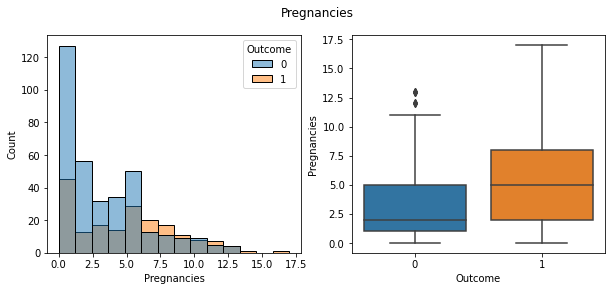

In [32]:
plot_histgram_and_boxplot(X_train.join(y_train), "Pregnancies")

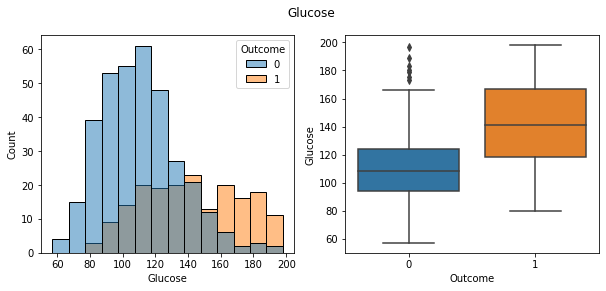

In [33]:
plot_histgram_and_boxplot(X_train.join(y_train), "Glucose")

In [34]:
# Algumas métricas de Glucose separadas por Outcome

X_train.join(y_train).loc[:, ['Outcome', 'Glucose']].groupby('Outcome').describe()

Glucose                                                           
          count        mean        std   min     25%    50%     75%    max
Outcome                                                                   
0         348.0  110.652299  23.818413  57.0   93.75  108.0  124.00  197.0
1         186.0  142.053763  29.810524  80.0  118.00  141.0  166.75  198.0

As médias são razoavelmente diferentes, mas os desvios são relativamentos próximos.

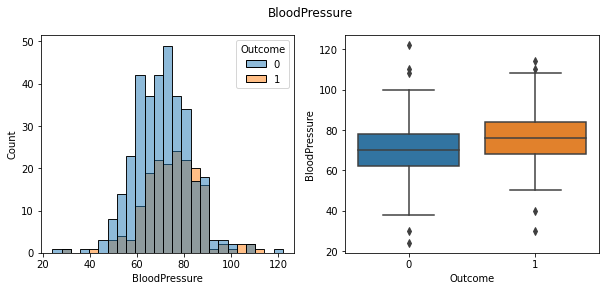

In [35]:
plot_histgram_and_boxplot(X_train.join(y_train), "BloodPressure")

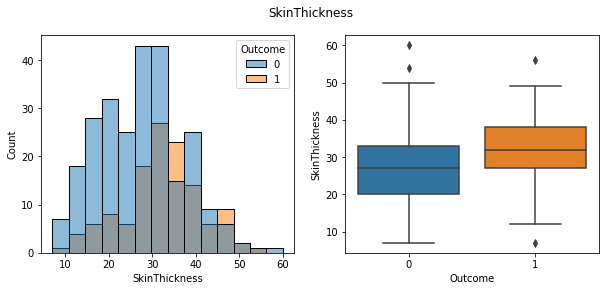

In [36]:
plot_histgram_and_boxplot(X_train.join(y_train), "SkinThickness")

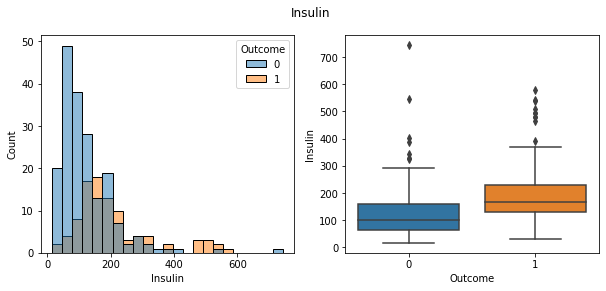

In [37]:
plot_histgram_and_boxplot(X_train.join(y_train), "Insulin")

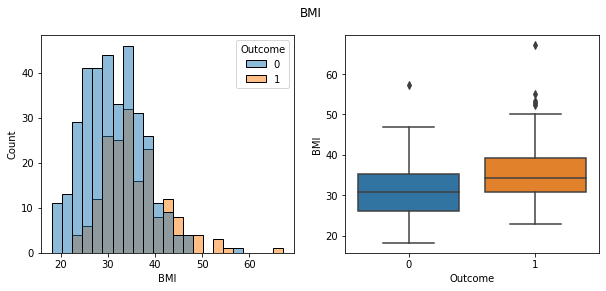

In [38]:
plot_histgram_and_boxplot(X_train.join(y_train), "BMI")

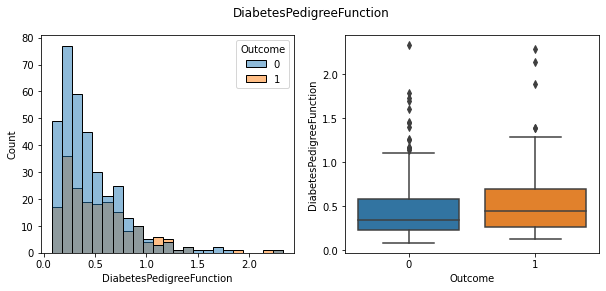

In [39]:
plot_histgram_and_boxplot(X_train.join(y_train), "DiabetesPedigreeFunction")

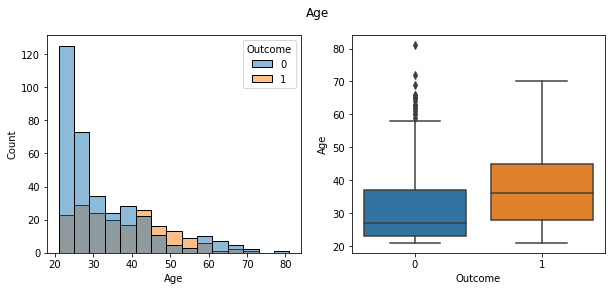

In [40]:
plot_histgram_and_boxplot(X_train.join(y_train), "Age")

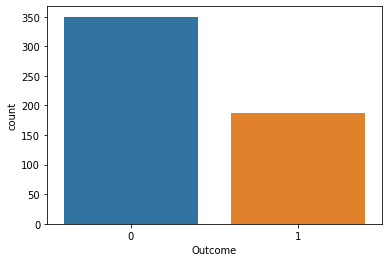

In [41]:
sns.countplot(data=X_train.join(y_train),  x='Outcome');

In [49]:
def correlacao(data):
    """
    Calcula coefiente de correlação (Spearman) das features com o target.
    """
    corr_matrix = data.corr(method='spearman')
    print(corr_matrix["Outcome"].sort_values(ascending=False))  

In [50]:
correlacao(X_train.join(y_train))

Outcome                     1.000000
Glucose                     0.477206
Insulin                     0.408592
BMI                         0.306924
Age                         0.291502
SkinThickness               0.253378
Pregnancies                 0.207352
BloodPressure               0.188599
DiabetesPedigreeFunction    0.153839
Name: Outcome, dtype: float64


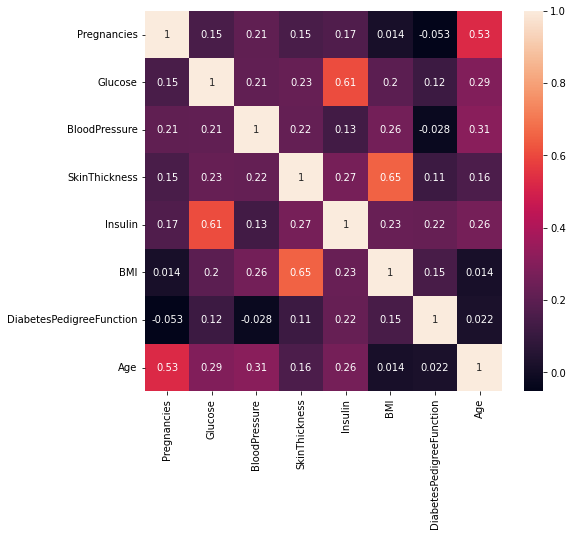

In [51]:
# Correlação (Pearson) entre todas as features

plt.figure(figsize=(8,7))
sns.heatmap(data=X_train.corr(), annot=True);

In [52]:
X_train.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.150844,0.206266,0.151273,0.167255,0.014023,-0.053033,0.526025
Glucose,0.150844,1.000000,0.212098,0.225636,0.605425,0.197783,0.115252,0.291124
BloodPressure,0.206266,0.212098,1.000000,0.220439,0.130892,0.259307,-0.027808,0.310865
SkinThickness,0.151273,0.225636,0.220439,1.000000,0.266078,0.652601,0.112280,0.159031
Insulin,0.167255,0.605425,0.130892,0.266078,1.000000,0.228691,0.223598,0.262166
BMI,0.014023,0.197783,0.259307,0.652601,0.228691,1.000000,0.147662,0.014409
DiabetesPedigreeFunction,-0.053033,0.115252,-0.027808,0.112280,0.223598,0.147662,1.000000,0.022122
Age,0.526025,0.291124,0.310865,0.159031,0.262166,0.014409,0.022122,1.000000


A partir da EDA podemos concluir que nossa *target* `Outcome` é suficientemente balanceada e é bem correlacionada com `Glucose`, `BMI`, `Age` e `Preganancies`. Entretanto, parece já existir uma dependência entre `Age` e `Preganancies`. Também parece haver algum grau de codepêndencia entre `SkinThickness`, `BMI` e `Insulin`.

## Modelo de referência

Nosso modelo heurístico é baseado no fato que a taxa de glicose deve ser o parâmetro mais importante para determinar se um paciente é diabético. Dito isto, vamos tentar achar um valor ideal de `Glucose` que nos dê a melhor acurácia.

In [58]:
# Criar um X,y para modelo de referência, dropando os NaNs

filtro_nan = X_train['Glucose'].isna()
index_nan = X_train[filtro_nan].index.tolist()

X_train_heuristic = X_train[['Glucose']].drop(index=index_nan)
y_train_heuristic = y_train.drop(index=index_nan)

In [59]:
# Treinando o modelo

glucose_thr = np.arange(62, 198, 1)
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []

def test_glucose(gl, thr):
    if gl >= thr:
        return 1
    else:
        return 0
    
for thr in glucose_thr:
    outcome_predict = X_train_heuristic["Glucose"].apply(test_glucose, thr=thr)
    
    accuracy = np.round(accuracy_score(y_train_heuristic, outcome_predict), 4)
    precision = np.round(precision_score(y_train_heuristic, outcome_predict), 4)
    recall = np.round(recall_score(y_train_heuristic, outcome_predict), 4)
    f1 = np.round(f1_score(y_train_heuristic, outcome_predict), 4)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

Utilizaremos o cruzamento entre precision e recall: ainda conservamos um bom recall, temos um alguma precisão e estamos um bom ponto de acurácia.

In [60]:
# Encontrando o ponto de acurácia máxima

accuracy_array = np.array(accuracy_list)
idx = accuracy_array.argmax()

train_recall = recall_list[idx]
train_precision = precision_list[idx]
train_accuracy = accuracy_list[idx]
train_f1 = f1_list[idx]

thr_heuristic = glucose_thr[idx]

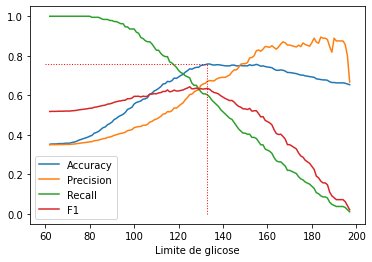

In [61]:
plt.plot(glucose_thr, accuracy_list, label='Accuracy')
plt.plot(glucose_thr, precision_list, label='Precision')
plt.plot(glucose_thr, recall_list, label='Recall')
plt.plot(glucose_thr, f1_list, label='F1')
plt.hlines(y=train_accuracy, xmin=60, xmax=thr_heuristic, linestyle=':', linewidth=1, color='r')
plt.vlines(x=thr_heuristic, ymin=0.0, ymax=train_accuracy, linestyle=':', linewidth=1, color='r')
plt.xlabel("Limite de glicose")
plt.legend()
plt.show()

In [62]:
# Print das métricas de treino

print("Métricas de treino:")
print(f"Acurácia: {train_accuracy}")
print(f"Precisão: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1: {train_f1}")

Métricas de treino:
Acurácia: 0.7584
Precisão: 0.6707
Recall: 0.6022
F1: 0.6346


Finalmente, vamos avaliar o modelo com os dados de teste. Essas métricas serão uma das nossas referências para avaliar a performace no final.

In [63]:
# Removendo NaN do teste

filtro_nan = X_test['Glucose'].isna()
index_nan = X_test[filtro_nan].index.tolist()

X_test_heuristic = X_test[['Glucose']].drop(index=index_nan)
y_test_heuristic = y_test.drop(index=index_nan)

In [64]:
# Predict no dataset de teste

outcome_predict = X_test_heuristic["Glucose"].apply(test_glucose, thr=thr_heuristic)

accuracy = np.round(accuracy_score(y_test_heuristic, outcome_predict), 4)
precision = np.round(precision_score(y_test_heuristic, outcome_predict), 4)
recall = np.round(recall_score(y_test_heuristic, outcome_predict), 4)
f1 = np.round(f1_score(y_test_heuristic, outcome_predict), 4)

print("Métricas de teste:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Métricas de teste:
Acurácia: 0.6943
Precisão: 0.5676
Recall: 0.525
F1: 0.5455


Ao final também iremos comparar a matriz de confusão:

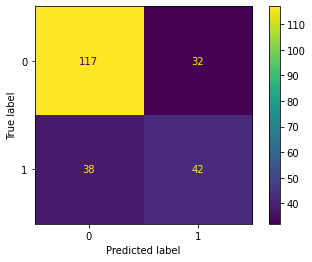

In [65]:
# Matriz de confusão para o modelo heurístico

cm_heuristic = confusion_matrix(y_test_heuristic, outcome_predict)
ConfusionMatrixDisplay(cm_heuristic).plot();

Naturalmente a acurácia é menor com os dados de teste, mas o recall desse modelo é significativamente baixo. Em particular tivemos um grande número de **falsos negativos**: pacientes que eram diabéticos mas que receberam diagnóstico negativo. Esse tipo de erro causa muito impacto nos custos de tratamento.

# Baseline ML

In [180]:
def relatorio_cross_val(estimator, X_train, y_train, cv=5):
    """Essa função será removida em prol da função validacao_cruzada."""
    
    cv_accuracy_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring="accuracy")
    cv_precision_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring="precision")
    cv_recall_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring="recall")
    
    cv_accuracy_mean_score = cv_accuracy_score.mean()
    cv_accuracy_std_score = cv_accuracy_score.std()
    
    cv_precision_mean_score = cv_precision_score.mean()
    cv_precision_std_score = cv_precision_score.std()
    
    cv_recall_mean_score = cv_recall_score.mean()
    cv_recall_std_score = cv_recall_score.std()
    
    print(f'Modelo: {estimator}')
    print(f"Acurácia média: {np.round(cv_accuracy_mean_score, 4)} (std={np.round(cv_accuracy_std_score, 4)})")
    print(f"Precisão média: {np.round(cv_precision_mean_score, 4)} (std={np.round(cv_precision_std_score, 4)})")
    print(f"Recall médio: {np.round(cv_recall_mean_score, 4)} (std={np.round(cv_recall_std_score, 4)})")

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos o mínimo tratamento dos dados ou otimizações nos modelos no momento. Utilizaremos **validação cruzada estratificada** uma vez que temos poucas instâncias no dataset e reservaremos o dataset de teste para a avaliação final.

In [172]:
def validacao_cruzada(X, y, estimator, cv=5, return_estimator=False, treatment=None, balancer=None):
    """
    Validação cruzada de n-folds, estratificada. Retorna médias da acurácia, precisão e recall.
    Retorna estimador de acordo com a flag return_estimator.
    Se houver balancer, faz balanceamento das classes.
    """

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    accuracy_array = np.zeros(cv)
    precision_array = np.zeros(cv)
    recall_array = np.zeros(cv)

    for i, (train_index, validation_index) in enumerate(skf.split(X, y)):
        # Split        
        X_train_split = X.iloc[train_index]
        y_train_split = y.iloc[train_index]
        
        X_val_split = X.iloc[validation_index]
        y_val_split = y.iloc[validation_index]

        # Tratamento
        if treatment:
            X_train_split = treatment.fit_transform(X_train_split, y_train_split)
            X_val_split = treatment.fit_transform(X_val_split, y_val_split)
        
        # Balanceamento
        
        if balancer:
            X_train_split, y_train_split = balancer.fit_resample(X_train_split, y_train_split)

        # Fit e predict
        estimator.fit(X_train_split, y_train_split)
        y_pred = estimator.predict(X_val_split)

        # Scoring

        accuracy_array[i] = accuracy_score(y_val_split, y_pred)
        precision_array[i] = precision_score(y_val_split, y_pred)
        recall_array[i] = recall_score(y_val_split, y_pred)
        
    # Priting results
    print(f'Modelo {estimator}')
    print(f'Acurácia: {accuracy_array.mean()} (std={accuracy_array.std()})')
    print(f'Precisão: {precision_array.mean()} (std={precision_array.std()})')
    print(f'Recall: {recall_array.mean()} (std={recall_array.std()})')
    
    if return_estimator:
        X = treatment.fit_transform(X, y)
        
        if balancer:
            X, ybalancer.fit_resample(X, y)
            
        estimator.fit(X, y)
        return estimator

### Decision Tree

Começaremos com uma **decision tree** para ganhar algum insight sobre os dados:

In [173]:
# Decision Tree

imp = SimpleImputer(strategy='constant', fill_value=0)
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

tree_clf = validacao_cruzada(X_train, y_train, tree_clf, return_estimator=True, treatment=imp)

Modelo DecisionTreeClassifier(max_depth=2, random_state=42)
Acurácia: 0.7467462789892696 (std=0.014770672745993956)
Precisão: 0.6896303441889181 (std=0.08044744958208114)
Recall: 0.5406827880512092 (std=0.09529564073659845)


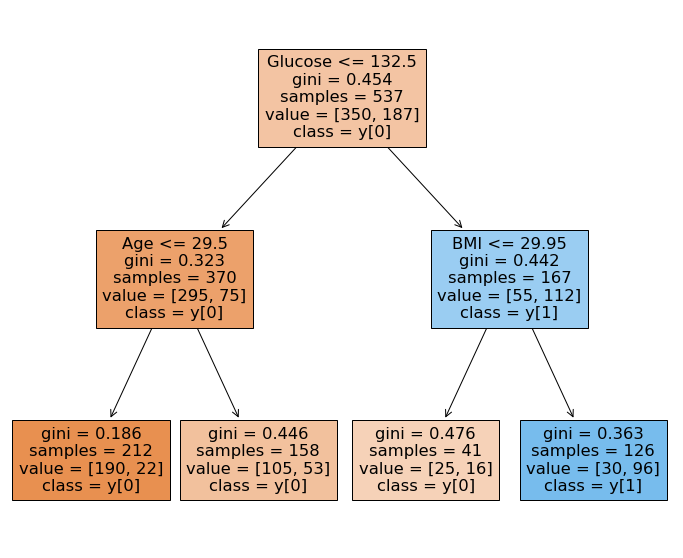

In [174]:
# Plotando árvore

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_train.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore simples, já temos uma acurácia razoável. Também confirmamos a expectativa de que `Glucose` é uma variável importante nesse problema.

### Logistic Regression

Também podemos treinar uma **regressão logística**, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [175]:
# Logistic Regression

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression()

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression()
Acurácia: 0.7933887158186224 (std=0.03438486777619503)
Precisão: 0.7589809299895507 (std=0.06474296550649572)
Recall: 0.5997155049786629 (std=0.06888569780654102)


### Random Forest

In [176]:
# Random Forest

imp = SimpleImputer(strategy='constant', fill_value=0)
forest_clf = RandomForestClassifier(random_state=42)

forest_clf = validacao_cruzada(X_train, y_train, forest_clf, treatment=imp, return_estimator=True)

Modelo RandomForestClassifier(random_state=42)
Acurácia: 0.7673589477327795 (std=0.03586709973984574)
Precisão: 0.704531490015361 (std=0.07086149873148931)
Recall: 0.588620199146515 (std=0.09250748360563006)


A partir da floresta treinada podemos extrair a importância de cada feature.

In [177]:
feature_importance = pd.DataFrame(zip(X_train.columns, forest_clf.feature_importances_),
                                  columns=['feature', 'importance']).sort_values(by='importance', 
                                                                                 ascending=False).reset_index(drop=True)
feature_importance

,feature,importance
0,Glucose,0.272161
1,BMI,0.151320
2,Age,0.129989
3,DiabetesPedigreeFunction,0.118306
4,Pregnancies,0.096944
5,BloodPressure,0.089079
6,Insulin,0.073077
7,SkinThickness,0.069124


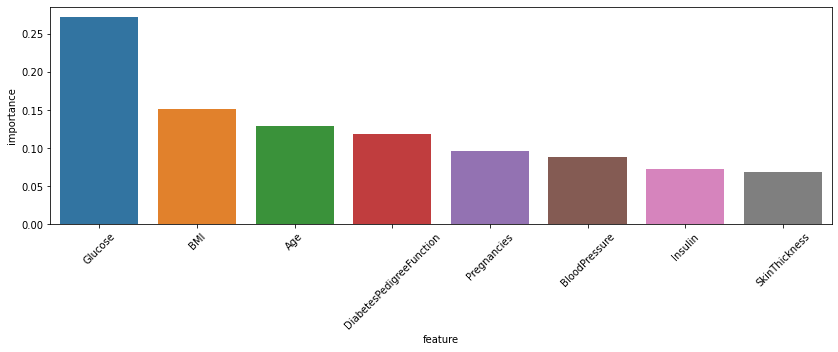

In [178]:
plt.figure(figsize=(14,4))
chart = sns.barplot(data=feature_importance, x='feature', y='importance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Confirmamos que `Glucose`, `BMI` e `Age` são variáveis importantes.

### Support Vector Machine

In [179]:
# Logistic Regression

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
svm_clf = SVC(kernel='linear')

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, svm_clf, treatment=tr_pipeline)

Modelo SVC(kernel='linear')
Acurácia: 0.789650398061613 (std=0.027314765125262565)
Precisão: 0.7570833333333333 (std=0.05897857426406835)
Recall: 0.5889046941678521 (std=0.0520478179420909)


Com esses modelos simples de ML já temos resultados significativamente melhores que o modelo heurístico.

# Tratamento dos dados

## Balanceamento das classes

In [181]:
# Sem balanceamento

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression()

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression()
Acurácia: 0.7933887158186224 (std=0.03438486777619503)
Precisão: 0.7589809299895507 (std=0.06474296550649572)
Recall: 0.5997155049786629 (std=0.06888569780654102)


In [182]:
# Usando class_weight

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight='balanced')

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight='balanced')
Acurácia: 0.7449463482173763 (std=0.018211532099481727)
Precisão: 0.613586479303408 (std=0.017371703669115675)
Recall: 0.7223328591749645 (std=0.05252305138387073)


Usar pesos com o parâmetro `class_weight` reduz um pouco a acurácia mas melhora nosso recall, o que é interessante para o tipo de problema que estamos resolvendo.

In [195]:
# Undersampling

from imblearn.under_sampling import NearMiss

nm = NearMiss(sampling_strategy=0.6, n_neighbors=3)

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight='balanced')

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline, balancer=nm)

Modelo LogisticRegression(class_weight='balanced')
Acurácia: 0.7394254067151264 (std=0.03270150664079517)
Precisão: 0.6038547560980494 (std=0.03443867367750166)
Recall: 0.7332859174964439 (std=0.05773216468208954)


In [197]:
# Oversampling

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.6, random_state=42)

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight='balanced')

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline, balancer=smote)

Modelo LogisticRegression(class_weight='balanced')
Acurácia: 0.7430944963655243 (std=0.020740895556022185)
Precisão: 0.6106146811140034 (std=0.01945991194025089)
Recall: 0.722475106685633 (std=0.05711977086231168)


In [ ]:
# Undersampling + oversampling



### Lidando com dados faltantes

Vamos comparar o SimpleImputer (testando média e mediana) e o KNNImputer.

In [54]:
# Testando SimpleImputer (mean)

sim_imp = SimpleImputer(strategy='mean')
std_scaler = StandardScaler()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)


relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.759 (std=0.0277)
Precisão média: 0.6445 (std=0.0478)
Recall médio: 0.7011 (std=0.0327)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7606 (std=0.0244)
Precisão média: 0.6912 (std=0.0462)
Recall médio: 0.5702 (std=0.0691)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7558 (std=0.0287)
Precisão média: 0.6456 (std=0.0469)
Recall médio: 0.6732 (std=0.0367)


In [55]:
# Testando SimpleImputer (median)

sim_imp = SimpleImputer(strategy='median')
std_scaler = StandardScaler()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)


relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7541 (std=0.0348)
Precisão média: 0.6373 (std=0.0564)
Recall médio: 0.7011 (std=0.0327)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7671 (std=0.0221)
Precisão média: 0.7006 (std=0.0524)
Recall médio: 0.5888 (std=0.0596)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7541 (std=0.0362)
Precisão média: 0.6432 (std=0.057)
Recall médio: 0.6779 (std=0.0381)


In [56]:
# Testando KNNImputer

knn_imp = KNNImputer(n_neighbors=15)
std_scaler = StandardScaler()

treat_steps = [('imputer', knn_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7525 (std=0.0374)
Precisão média: 0.6351 (std=0.0595)
Recall médio: 0.7011 (std=0.0327)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7703 (std=0.0239)
Precisão média: 0.7011 (std=0.0576)
Recall médio: 0.6029 (std=0.0408)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7606 (std=0.0276)
Precisão média: 0.6551 (std=0.0498)
Recall médio: 0.6731 (std=0.0311)


Vamos usar o tratamento do `KNNImputer` com a `n_neighbors=15`. Antes de prosseguir vamos analisar novamente os dados após o tratamento.

In [57]:
# Reconstruindo o dataframe

X_train_impute = pd.DataFrame(knn_imp.fit_transform(X_train), 
                              columns=X_train.columns, 
                              index=X_train.index)

X_train_impute.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1.0,90.0,62.0,12.0,43.000000,27.200001,0.580,24.0
711,5.0,126.0,78.0,27.0,22.000000,29.600000,0.439,40.0
373,2.0,105.0,58.0,40.0,94.000000,34.900002,0.225,25.0
46,1.0,146.0,56.0,27.2,207.733333,29.700001,0.564,29.0
682,0.0,95.0,64.0,39.0,105.000000,44.599998,0.366,22.0


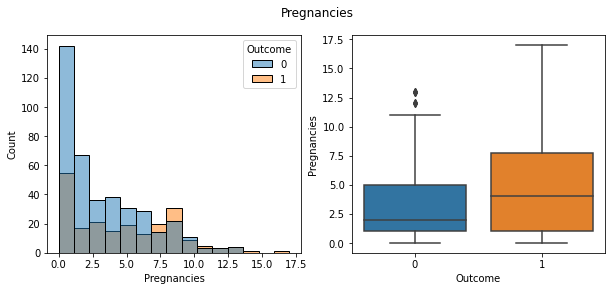

In [58]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Pregnancies")

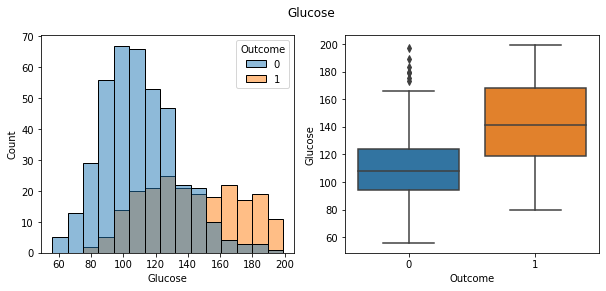

In [59]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Glucose")

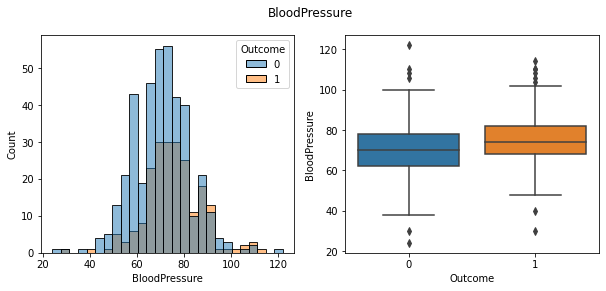

In [60]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "BloodPressure")

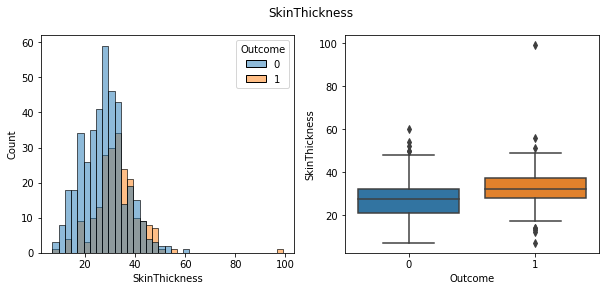

In [61]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "SkinThickness")

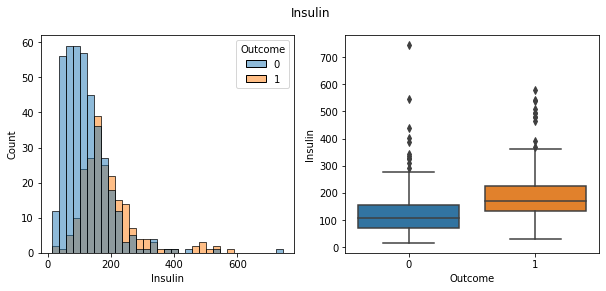

In [62]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Insulin")

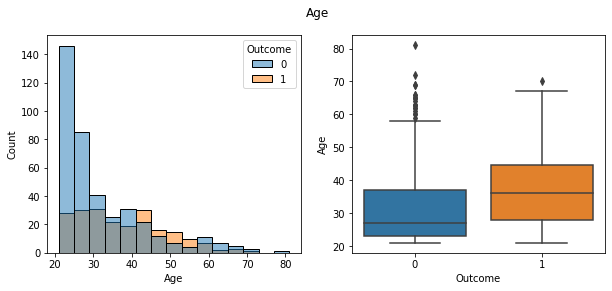

In [63]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Age")

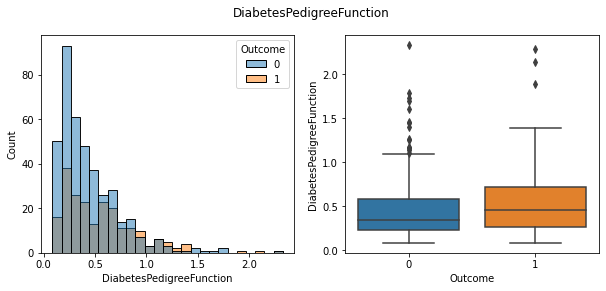

In [64]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "DiabetesPedigreeFunction")

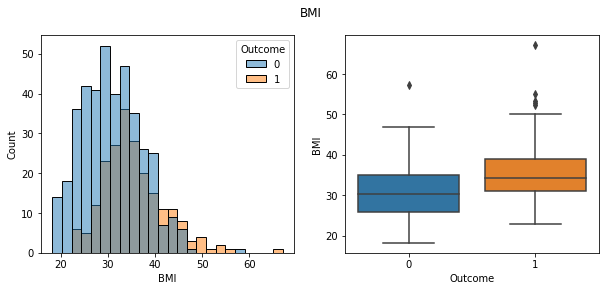

In [65]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "BMI")

Vamos verificar novamente a matriz de correlação.

In [66]:
corr_matrix = X_train_impute.join(y_train).corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.514116
Insulin                     0.377782
BMI                         0.330768
SkinThickness               0.286682
Age                         0.240676
Pregnancies                 0.208173
BloodPressure               0.184225
DiabetesPedigreeFunction    0.165312
Name: Outcome, dtype: float64


As distribuições se mantiveram sem muitas distorções. Nota-se que temos uma melhor correlação de diversas features com o target.

### Log transformation

A distribuição da `DiabetesPedigreeFunction` e `Insulin `parecem muito inviesadas. Aplicar um logaritmo pode ajudar a torna-las mais normais, o que ajuda nossos modelos:

In [67]:
X_train_log = X_train_impute.copy()
X_train_log.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1.0,90.0,62.0,12.0,43.000000,27.200001,0.580,24.0
711,5.0,126.0,78.0,27.0,22.000000,29.600000,0.439,40.0
373,2.0,105.0,58.0,40.0,94.000000,34.900002,0.225,25.0
46,1.0,146.0,56.0,27.2,207.733333,29.700001,0.564,29.0
682,0.0,95.0,64.0,39.0,105.000000,44.599998,0.366,22.0


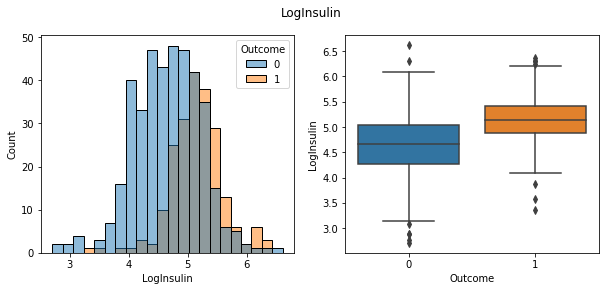

In [68]:
X_train_log['LogInsulin'] = np.log(X_train_log['Insulin'])
plot_histgram_and_boxplot(X_train_log.join(y_train), "LogInsulin")

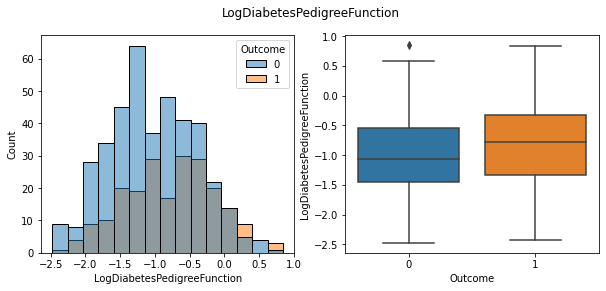

In [69]:
X_train_log['LogDiabetesPedigreeFunction'] = np.log(X_train_log['DiabetesPedigreeFunction'])
plot_histgram_and_boxplot(X_train_log.join(y_train), "LogDiabetesPedigreeFunction")

In [70]:
correlacao(X_train_log.join(y_train))

Outcome                        1.000000
Glucose                        0.514116
LogInsulin                     0.418781
Insulin                        0.377782
BMI                            0.330768
SkinThickness                  0.286682
Age                            0.240676
Pregnancies                    0.208173
BloodPressure                  0.184225
LogDiabetesPedigreeFunction    0.174461
DiabetesPedigreeFunction       0.165312
Name: Outcome, dtype: float64


As distribuições parecem mais normais e as correlações melhoraram.

In [71]:
drop = ["DiabetesPedigreeFunction", "Insulin"]
X_train_log = X_train_log.drop(drop, axis=1)
X_train_log.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogInsulin,LogDiabetesPedigreeFunction
353,1.0,90.0,62.0,12.0,27.200001,24.0,3.761200,-0.544727
711,5.0,126.0,78.0,27.0,29.600000,40.0,3.091042,-0.823256
373,2.0,105.0,58.0,40.0,34.900002,25.0,4.543295,-1.491655
46,1.0,146.0,56.0,27.2,29.700001,29.0,5.336255,-0.572701
682,0.0,95.0,64.0,39.0,44.599998,22.0,4.653960,-1.005122


In [72]:
X_train_sc = std_scaler.fit_transform(X_train_log)

relatorio_cross_val(log_clf, X_train_sc, y_train)
print()
relatorio_cross_val(forest_clf, X_train_sc, y_train)
print()
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7557 (std=0.0256)
Precisão média: 0.632 (std=0.0383)
Recall médio: 0.7243 (std=0.0453)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7671 (std=0.0197)
Precisão média: 0.695 (std=0.0452)
Recall médio: 0.5982 (std=0.0441)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7557 (std=0.0112)
Precisão média: 0.6366 (std=0.0205)
Recall médio: 0.701 (std=0.0336)


Os resultados desse tratamento foram interessantes. Vamos usá-los.

### Binning

Vamos tentar agora agrupar dados para reduzir o ruído de alguma feature. Como discutido, fazer esse tratamento isso na `Age` talvez ajude nosso modelo. 

In [73]:
X_train_bins = X_train_log.copy()
X_train_bins.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogInsulin,LogDiabetesPedigreeFunction
353,1.0,90.0,62.0,12.0,27.200001,24.0,3.761200,-0.544727
711,5.0,126.0,78.0,27.0,29.600000,40.0,3.091042,-0.823256
373,2.0,105.0,58.0,40.0,34.900002,25.0,4.543295,-1.491655
46,1.0,146.0,56.0,27.2,29.700001,29.0,5.336255,-0.572701
682,0.0,95.0,64.0,39.0,44.599998,22.0,4.653960,-1.005122


Usaremos `KBinsDiscretizer`:

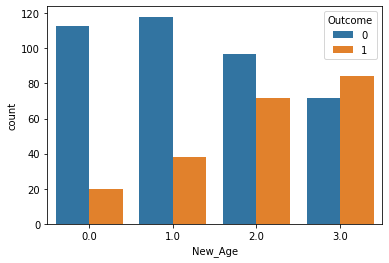

In [74]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_train_bins["New_Age"] = kbins.fit_transform(X_train_bins[['Age']])

sns.countplot(data=X_train_bins.join(y_train), x="New_Age", hue='Outcome');

In [75]:
correlacao(X_train_bins.join(y_train))

Outcome                        1.000000
Glucose                        0.514116
LogInsulin                     0.418781
BMI                            0.330768
New_Age                        0.309682
SkinThickness                  0.286682
Age                            0.240676
Pregnancies                    0.208173
BloodPressure                  0.184225
LogDiabetesPedigreeFunction    0.174461
Name: Outcome, dtype: float64


A correlação melhorou.

In [76]:
# Testando

X_train_bins = X_train_bins.drop('Age', axis=1)

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_bins)

relatorio_cross_val(log_clf, X_train_sc, y_train)
print()
relatorio_cross_val(forest_clf, X_train_sc, y_train)
print()
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7639 (std=0.0437)
Precisão média: 0.6435 (std=0.0632)
Recall médio: 0.7386 (std=0.0638)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7524 (std=0.0196)
Precisão média: 0.6844 (std=0.0504)
Recall médio: 0.5468 (std=0.0362)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7541 (std=0.0359)
Precisão média: 0.6296 (std=0.0525)
Recall médio: 0.7295 (std=0.0718)


O tratamento é semelhante à uma condificação por faixa etária (criança, jovem, adulto, idoso). Melhoramos nosso resultado e simplificamos nosso modelo. Seguiremos com esse tratamento.

## Quantile Scaling

`BMI` parece ser uma feature importante, mas talvez precise ser ajustada e seus outliers tratados. Vamos testar um QuantileTransformer.

In [77]:
X_train_scaling = X_train_bins.copy()
X_train_scaling.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,LogInsulin,LogDiabetesPedigreeFunction,New_Age
353,1.0,90.0,62.0,12.0,27.200001,3.761200,-0.544727,1.0
711,5.0,126.0,78.0,27.0,29.600000,3.091042,-0.823256,2.0
373,2.0,105.0,58.0,40.0,34.900002,4.543295,-1.491655,1.0
46,1.0,146.0,56.0,27.2,29.700001,5.336255,-0.572701,2.0
682,0.0,95.0,64.0,39.0,44.599998,4.653960,-1.005122,0.0


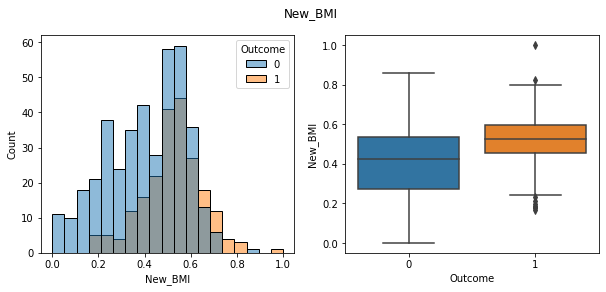

In [78]:
qt = QuantileTransformer(n_quantiles=3, random_state=42)
X_train_scaling[['New_BMI']] = qt.fit_transform(X_train_scaling[['BMI']])
plot_histgram_and_boxplot(X_train_scaling.join(y_train), "New_BMI")

In [79]:
# Testando o QuantileTransformer

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_scaling)

relatorio_cross_val(log_clf, X_train_sc, y_train)
print()
relatorio_cross_val(forest_clf, X_train_sc, y_train)
print()
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7655 (std=0.0338)
Precisão média: 0.6451 (std=0.0568)
Recall médio: 0.748 (std=0.0528)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7589 (std=0.036)
Precisão média: 0.6864 (std=0.0777)
Recall médio: 0.5843 (std=0.0526)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7557 (std=0.0387)
Precisão média: 0.6289 (std=0.0534)
Recall médio: 0.7433 (std=0.0596)


Essa transformação nos rendeu um bom resultado. Vamos seguir com ela.

## Final pipeline

In [80]:
log_transform = FunctionTransformer(np.log)
qt = QuantileTransformer(n_quantiles=3, random_state=42)
std_scaler = StandardScaler()

ct = ColumnTransformer([('log_transform', log_transform, [4, 6]),
                        ('kbins', kbins, [7]),
                        ('quantile', qt, [5])
                       ], remainder='passthrough')


final_pipeline = Pipeline([('imputer', knn_imp), ('col_tr', ct), ('scaler', std_scaler)])

final_columns = ['log_Insulin', 'log_DiabetesPedigreeFunction', 'new_Age', 'new_BMI', 
                 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness'
                ]

final_pipeline.fit(X_train)
X_train_tr = pd.DataFrame(final_pipeline.transform(X_train), columns=final_columns, index=X_train.index)
X_train_tr.head()

,log_Insulin,log_DiabetesPedigreeFunction,new_Age,new_BMI,Pregnancies,Glucose,BloodPressure,SkinThickness
353,-1.841758,0.624131,-0.520238,-0.772911,-0.851355,-1.056417,-0.823676,-1.860289
711,-3.002344,0.191325,0.397653,-0.262937,0.356576,0.144085,0.476545,-0.231105
373,-0.487319,-0.847301,-0.520238,0.549421,-0.549372,-0.556208,-1.148731,1.180855
46,0.885938,0.580662,0.397653,-0.241688,-0.851355,0.811030,-1.311259,-0.209382
682,-0.295667,-0.091277,-1.438129,1.392886,-1.153338,-0.889681,-0.661149,1.072242


In [81]:
relatorio_cross_val(log_clf, X_train_tr, y_train)
print()
relatorio_cross_val(forest_clf, X_train_tr, y_train)
print()
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced')
Acurácia média: 0.7639 (std=0.0417)
Precisão média: 0.6427 (std=0.0683)
Recall médio: 0.7526 (std=0.049)

Modelo: RandomForestClassifier(class_weight='balanced', random_state=42)
Acurácia média: 0.7589 (std=0.0352)
Precisão média: 0.694 (std=0.0829)
Recall médio: 0.5701 (std=0.0345)

Modelo: SVC(class_weight='balanced', kernel='linear')
Acurácia média: 0.7492 (std=0.0387)
Precisão média: 0.6232 (std=0.0547)
Recall médio: 0.7247 (std=0.0653)


## Modelos finais

In [82]:
# Aplicando a pipeline ao treino
X_train_tr = final_pipeline.fit_transform(X_train)

### Logistic regression

In [83]:
log_clf = LogisticRegression(solver='liblinear', class_weight='balanced')
log_clf.fit(X_train_tr, y_train)
relatorio_cross_val(log_clf, X_train_tr, y_train)

Modelo: LogisticRegression(class_weight='balanced', solver='liblinear')
Acurácia média: 0.7639 (std=0.0417)
Precisão média: 0.6427 (std=0.0683)
Recall médio: 0.7526 (std=0.049)


In [84]:
# Vamos otimizar para recall com GridSearchCV

params = {'penalty':['l1', 'l2'], 'C':np.arange(0.1, 2.1, 0.1)}

log_grid_search_cv = GridSearchCV(log_clf, params, cv=5, scoring='recall')
log_grid_search_cv.fit(X_train_tr, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [85]:
# Reservando o modelo
log_clf = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

log_clf.fit(X_train_tr, y_train)
relatorio_cross_val(log_clf, X_train_tr, y_train)

Modelo: LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
Acurácia média: 0.7606 (std=0.0314)
Precisão média: 0.6293 (std=0.0444)
Recall médio: 0.776 (std=0.0592)


## Random Forest

In [86]:
# # Randomized Search CV para a Random Forest

# forest_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "min_samples_split": [2,5,10,30],
#                "max_features": [3,4,5,6,7]
#               }
# forest_randcv = RandomizedSearchCV(forest_clf, params_grid, n_iter=100, cv=5, scoring='recall', verbose=2, n_jobs=-1)
# forest_randcv.fit(X_train_tr, y_train)

In [87]:
# Melhor floresta que treinei até o momento

forest_clf = RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=5,
                       min_samples_split=30, n_estimators=600, random_state=42)



# Vamos reservar um modelo treinado para fazer um ensemble
forest_clf.fit(X_train_tr, y_train)

relatorio_cross_val(forest_clf, X_train_tr, y_train)

Modelo: RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=5,
                       min_samples_split=30, n_estimators=600, random_state=42)
Acurácia média: 0.7622 (std=0.0243)
Precisão média: 0.6324 (std=0.0396)
Recall médio: 0.7712 (std=0.0532)


### XGBoost

In [88]:
# # Randomized Search CV para a XGBoost

# xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, n_estimators=500, random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "learning_rate": np.linspace(0,1,11)
#               }
# xgb_randcv = RandomizedSearchCV(xgb_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
# xgb_randcv.fit(X_train_tr, y_train)

# print(f'Melhor estimador:{xgb_randcv.best_params_}')
# relatorio_cross_val(xgb_randcv.best_estimator_, X_train_tr, y_train)

In [89]:
# Grid Search CV para XGB

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)
# grid_search_cv.best_estimator_
# grid_search_cv.best_score_

In [90]:
# # Vamos reservar um modelo treinado para fazer um ensemble

# xgb_clf = XGBClassifier(learning_rate=0.8, 
#                         max_depth=5, 
#                         n_estimators=500,
#                         random_state=42)

# xgb_clf.fit(X_train_tr, y_train)
# relatorio_cross_val(xgb_clf, X_train_tr, y_train)

## Support-vector machine

In [91]:
svc_clf = SVC(kernel='rbf', C=1.0, probability=True, class_weight='balanced')
svc_clf.fit(X_train_tr, y_train)
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Modelo: SVC(class_weight='balanced', probability=True)
Acurácia média: 0.746 (std=0.037)
Precisão média: 0.6092 (std=0.0521)
Recall médio: 0.7804 (std=0.043)


In [92]:
# Do a gridsearch

### Majority hard vote 

In [93]:
# Add xgboost later

estimators = [('forest', forest_clf), ('svc', svc_clf), ('log', log_clf)]
voting_hard_clf = VotingClassifier(estimators, voting='hard')
voting_hard_clf.fit(X_train_tr, y_train)
relatorio_cross_val(voting_hard_clf, X_train_tr, y_train)

Modelo: VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_features=5,
                                                     min_samples_split=30,
                                                     n_estimators=600,
                                                     random_state=42)),
                             ('svc',
                              SVC(class_weight='balanced', probability=True)),
                             ('log',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 penalty='l1',
                                                 solver='liblinear'))])
Acurácia média: 0.7639 (std=0.0281)
Precisão média: 0.6323 (std=0.04)
Recall médio: 0.7805 (std=0.0517)


### Majority soft vote 

In [94]:
# Add xgboost later

estimators = [('forest', forest_clf), ('svc', svc_clf), ('log', log_clf)]
voting_soft_clf = VotingClassifier(estimators, voting='soft')
voting_soft_clf.fit(X_train_tr, y_train)
relatorio_cross_val(voting_soft_clf, X_train_tr, y_train)

Modelo: VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_features=5,
                                                     min_samples_split=30,
                                                     n_estimators=600,
                                                     random_state=42)),
                             ('svc',
                              SVC(class_weight='balanced', probability=True)),
                             ('log',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 penalty='l1',
                                                 solver='liblinear'))],
                 voting='soft')
Acurácia média: 0.7687 (std=0.0375)
Precisão média: 0.6517 (std=0.0521)
Recall médio: 0.7433 (std=0.0596)


Os modelos que se mostraram mais interessantes foram o **SVM** e o **Majority Hard Vote**. Dado que as performaces são semelhantes, escolheriamos aqui o modelo SVM por este ser mais simples e rápido. 

## Avaliação final do modelo

In [95]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
44,7,159.0,64.0,NaN,NaN,27.400000,0.294,40
672,10,68.0,106.0,23.0,49.0,35.500000,0.285,47
700,2,122.0,76.0,27.0,200.0,35.900002,0.483,26
630,7,114.0,64.0,NaN,NaN,27.400000,0.732,34
81,2,74.0,NaN,NaN,NaN,NaN,0.102,22


In [96]:
# Tratamento dos dados de teste

X_test_tr = final_pipeline.transform(X_test)

In [97]:
def metrics_report(y_test, y_pred):
    accuracy = np.round(accuracy_score(y_test, y_pred), 4)
    precision = np.round(precision_score(y_test, y_pred), 4)
    recall = np.round(recall_score(y_test, y_pred), 4)
    f1 = np.round(f1_score(y_test, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print(f"F1 score: {f1}")
    print("-------------------------- \n")

In [98]:
models = [forest_clf, svc_clf, log_clf, voting_hard_clf, voting_soft_clf]
models_names = ["Random Forest", "SVM", "Log. Reg.", "Hard voting", "Soft voting"]

for name, model in zip(models_names, models):
    y_pred = model.predict(X_test_tr)
    print(f"*Results for {name} \n")
    metrics_report(y_test, y_pred)

*Results for Random Forest 

Accuracy score: 0.7403
Precision score: 0.6
Recall score: 0.7778
F1 score: 0.6774
-------------------------- 

*Results for SVM 

Accuracy score: 0.7403
Precision score: 0.6
Recall score: 0.7778
F1 score: 0.6774
-------------------------- 

*Results for Log. Reg. 

Accuracy score: 0.7403
Precision score: 0.6029
Recall score: 0.7593
F1 score: 0.6721
-------------------------- 

*Results for Hard voting 

Accuracy score: 0.7403
Precision score: 0.6029
Recall score: 0.7593
F1 score: 0.6721
-------------------------- 

*Results for Soft voting 

Accuracy score: 0.7468
Precision score: 0.619
Recall score: 0.7222
F1 score: 0.6667
-------------------------- 



Os resultados de teste e treino foram próximos o suficiente para que não caracterizassemos *overfitting*. Ademais, nosso modelo de SVM ainda continuou com resultados interessantes.

# Conclusões

Finalmente vamos consolidar os resultados.

In [99]:
print("Métricas de teste do modelo heurístico:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Métricas de teste do modelo heurístico:
Acurácia: 0.7059
Precisão: 0.6216
Recall: 0.4259
F1: 0.5055


In [100]:
y_pred = svc_clf.predict(X_test_tr)
print('Métricas de teste do modelo final (SVM)')
metrics_report(y_test, y_pred)

Métricas de teste do modelo final (SVM)
Accuracy score: 0.7403
Precision score: 0.6
Recall score: 0.7778
F1 score: 0.6774
-------------------------- 



Uma métrica importante foi bastante melhor: o recall. Além disso, ganhamos um pouco de acurácia, ao custo de uma pequena redução da precisão. Do ponto de vista de saúde pública isso é interessante: queremos alcançar todos os possíveis diabéticos, ainda que reduzindo um pouco a precisão. 

Outra métrica que demonstra que nosso modelo é mais equilibrado é a F1: modelos com recall e precisão semelhantes tem melhor resultado. 

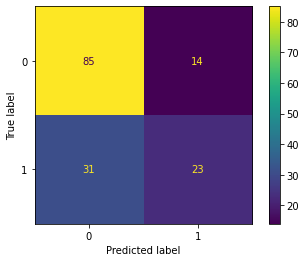

In [101]:
# Matriz de confusão do modelo heurístico

ConfusionMatrixDisplay(cm_heuristic).plot();

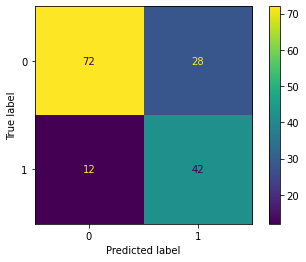

In [102]:
# Matriz de confusão do nosso modelo com ML
cm_ml = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_ml).plot();

Atingimos nosso objetivo de reduzir significativamente o número de falsos negativos de 20,2% para 7,8%. O número de falsos positvos aumentou, mas isso causa menos impacto financeiro.

Consideremos o seguinte cenário hipotético de custos por paciente. Tomaremos como base de que o custo de um paciente diabético com o diagnóstico correto tenha o custo de $R\$100,00$ e que o custo de tratamento de um não-diabético (tratamento preventivo) seja $R\$20,00$. O custo de um paciente falso negativo deve ser mais alto, já que significa que atrasamos o tratamento ideal. Vamos estimá-lo em $R\$130,00$. O custo por falso positivo é intermediário e vamos orçá-lo em $R\$40,00$.

In [103]:
cost_matrix = np.array([[20, 40],
                        [130, 100]])

ml_cost = cost_matrix * cm_ml
heuristic_cost = cost_matrix * cm_heuristic

ml_cost_sum = ml_cost.sum()
heuristic_cost_sum = heuristic_cost.sum()

print(f'{100*(1 - ml_cost_sum / heuristic_cost_sum):.3f}')

3.143


Nesses moldes, temos então uma redução de custos de 3,14% por paciente.

# Deploy

In [114]:
# Criar uma pipeline para o deploy unindo o tratamento e a previsão

model_pipeline = Pipeline([('treatment', final_pipeline), ('svm', svc_clf)])
model_pipeline

Pipeline(steps=[('treatment',
                 Pipeline(steps=[('imputer', KNNImputer(n_neighbors=15)),
                                 ('col_tr',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>),
                                                                   [4, 6]),
                                                                  ('kbins',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=4),
                                                                   [7]),
                                                                  ('quantile',
                                                                   QuantileTransformer(n_quantiles=3,
                                                                                       random_state=42),
                                                                   [5])])),
                                 ('scaler', StandardScaler())])),
                ('svm', SVC(class_weight='balanced', probability=True))])

In [121]:
# Fazendo o dump

import joblib
import os

joblib.dump(model_pipeline, os.path.join('model.pkl'))

['model.pkl']